## 1. Packages & Parallel Processing Setup

In [ ]:
# Initialize Distributed Workers
using Distributed
if nworkers() == 1
    addprocs(10)
end
nworkers()
using Random, Statistics
using Plots
using ProgressMeter
default(fmt=:png, dpi=300) # set default plot format to PNG
@everywhere begin
    using Agents, Random, Statistics
end

## 2. Agent definition

In [ ]:
# Define Agent Type 
# Single-opinion agent (xi ∈ [-1, 1]) on a 2D lattice
@everywhere begin
    @agent struct OP(GridAgent{2}) # 2D grid agent
        opinion::Float64
    end
end

## 3. Helper - sample two distinct agents 

In [ ]:
# Get Two Distinct Agent IDs
# Well-mixed Case
# Could also use random_id(model) from Agents.jl, but this shows the logic. 
@everywhere begin
    @inline function two_distinct_ids(n::Int) # Sample two distinct agent IDs from 1:n uniformly
        i = rand(1:n)
        j = rand(1:(n-1))
        j >= i && (j += 1)
        return i, j
    end
end


## 4. Model initialization

In [ ]:
# Model initialization
# Opinions drawn uniformly from [-1, 1]
# Periodic grid space with Manhattan distance metric

@everywhere begin
    function initialize(; M=10, # Initialization function for the model
        local_int=false, # Whether to use local interactions (true) or well-mixed (false)
        learning_rate=0.5,
        consensus_threshold=0.05,
        interaction_mode::Symbol=:positive,  # :positive | :bounded | :negative
        confidence_threshold=0.10
    )
        space = GridSpaceSingle((M, M); periodic=true, metric=:manhattan)

        props = Dict(
            :local_int => local_int,
            :learning_rate => learning_rate,
            :consensus_threshold => consensus_threshold,
            :interaction_mode => interaction_mode,
            :confidence_threshold => confidence_threshold,
            :consensus => false,)

        model = StandardABM(OP, space; model_step!, properties=props,
            scheduler=Schedulers.Randomly())

        for _ in 1:M^2 # Fill the grid with agents
            add_agent_single!(model; opinion=2 .* rand() .- 1) # Opinions in [-1, 1]
        end
        return model
    end
end

## 5. Interaction mechanism 

In [ ]:
# Interaction between two agents based on the selected mechanism
@everywhere function interact!(a::OP, b::OP, model)
    x1, x2 = a.opinion, b.opinion
    lr = model.learning_rate
    d = model.confidence_threshold
    mode = model.interaction_mode
    Δ = abs(x1 - x2)

    if mode === :positive
        x1n = x1 + lr * (x2 - x1)
        x2n = x2 + lr * (x1 - x2)

    elseif mode === :bounded
        Δ < d || return
        x1n = x1 + lr * (x2 - x1)
        x2n = x2 + lr * (x1 - x2)

    elseif mode === :negative
        if Δ < d
            x1n = x1 + lr * (x2 - x1)
            x2n = x2 + lr * (x1 - x2)

        elseif Δ > d
            if x1 > x2
                x1n = x1 + lr * (x1 - x2) * (1 - x1) * 0.5
                x2n = x2 + lr * (x2 - x1) * (1 + x2) * 0.5
            else
                x1n = x1 + lr * (x1 - x2) * (1 + x1) * 0.5
                x2n = x2 + lr * (x2 - x1) * (1 - x2) * 0.5
            end
        else
            # Δ == d: no change
            return
        end
    end

    a.opinion = x1n
    b.opinion = x2n
end


## 6. Helper - clique detection - counting

In [ ]:
# Clique detection and counting functions
@everywhere begin
    # Find opinion ranges of cliques in the model 
    function clique_ranges(model)::Vector{Float64}
        d = model.confidence_threshold
        xs = sort!([a.opinion for a in allagents(model)])
        n = length(xs)
        ranges = Float64[]
        cmin = xs[1]
        cmax = xs[1]
        prev = xs[1]

        @inbounds for k in 2:n
            x = xs[k]
            if (x - prev) > d
                push!(ranges, cmax - cmin)
                cmin = x
                cmax = x
            else
                cmax = x
            end
            prev = x
        end

        push!(ranges, cmax - cmin)
        return ranges
    end

    # Count number of cliques in the model 
    function num_cliques(model)::Int
        d = model.confidence_threshold
        opinions = [a.opinion for a in allagents(model)]

        cliques = 1 # At least one clique exists

        if model.interaction_mode === :negative # Negative interaction mode
            cand = filter(x -> x > (0.5d), opinions)
        else
            cand = filter(x -> x > (-1 + 0.5d), opinions) # Positive or bounded interaction mode
        end

        isempty(cand) && return 1
        min_value = minimum(cand)

        while any(x -> (x > (min_value + d)) && (x < (1 - 0.5d)), opinions) # There exists an opinion gap > d
            cand2 = filter(x -> x > (min_value + 0.5d), opinions)
            isempty(cand2) && break
            min_value = minimum(cand2)
            cliques += 1
        end

        return cliques
    end

end


## 7. Dynamics - model_step! 

In [ ]:
# Define Model Step Function where agents interact
@everywhere begin
    function model_step!(model)
        n = nagents(model)

        # Select two agents to interact
        if model.local_int == false
            i, j = two_distinct_ids(n)
            a = model[i]
            b = model[j]
        else
            a = model[rand(1:n)]
            b = model[random_nearby_id(a, model, 1)] # random_nearby_id(a, model, 1) is from Agents.jl
        end

        interact!(a, b, model)


        # Check for consensus
        ranges = clique_ranges(model)
        if !isempty(ranges) && all(r -> r < model.consensus_threshold, ranges) && !model.consensus
            model.consensus = true
        end
    end
end


## 8. Helper - running simulation batches

In [ ]:
# Simulation and Trial Functions
@everywhere begin
    function rununtil(model; max_steps::Int=200000, # Run the model until consensus or max_steps
        timeseries=nothing,
        record_every::Int=1,
        record_cliques::Bool=false)

        t = 0
        while t < max_steps && !model.consensus # Run until consensus or max_steps
            step!(model, 1)
            t += 1

            if timeseries !== nothing && (t % record_every == 0) # record data every record_every steps
                push!(timeseries.t, t)
                push!(timeseries.opinions, [a.opinion for a in allagents(model)])
                if record_cliques && timeseries.cliques !== nothing
                    push!(timeseries.cliques, num_cliques(model))
                end
            end
        end
        return model
    end

    function run_trial(lr, dthr, mode_sym; # Run a single trial of the model with given parameters
        M=50, local_int=false, max_steps=200000, record_every::Int=1)

        model = initialize(; M=M, local_int=local_int, learning_rate=lr,
            consensus_threshold=0.05,
            interaction_mode=mode_sym,
            confidence_threshold=dthr
        )
        rununtil(model; max_steps=max_steps,
            record_every=record_every)

        return (num_cliques(model))
    end

    function run_trials_with_cliquesvec(lr, dthr, mode_sym; # Run multiple trials and return average time and cliques
        n_trials::Int=10, M::Int=10, local_int::Bool=false, max_steps::Int=200000)

        clq = Vector{Float64}(undef, n_trials)

        for trial in 1:n_trials
            c = run_trial(lr, dthr, mode_sym; M=M, local_int=local_int, max_steps=max_steps)
            clq[trial] = c
        end

        return (mean(clq), clq)
    end
end



## 9. Helper - sweep confidence threshold and plot - Figure 5.4A

In [ ]:
# Parameter sweep over confidence threshold d (Figure 5.4A).

function sweep_mechanism(; interaction_mode::Symbol=:bounded, # Sweep over confidence thresholds for a given interaction mechanism
    learning_rate_fixed=0.20,
    confidence_thresholds=collect(0.01:0.02:0.70),
    n_trials=30, M=10, local_int=false,
    max_steps=20000, batch_size=4)

    mode_sym = interaction_mode
    n_thr = length(confidence_thresholds)
    mean_cliques = zeros(n_thr)
    cliques_trials = Matrix{Float64}(undef, n_thr, n_trials)

    # Distributed worker warmup 
    @sync for w in workers()
        @async remotecall_wait(w) do
            m = initialize(M=5, local_int=false, learning_rate=learning_rate_fixed,
                interaction_mode=mode_sym, confidence_threshold=0.1
            )
            step!(m, 1)
            nothing
        end
    end

    # Run sweep in parallel
    combo_index = [(j, d) for (j, d) in enumerate(confidence_thresholds)]
    println("Running sweep mode=$(mode_sym) with ", length(combo_index),
        " thresholds on ", nworkers(), " workers...")

    p = Progress(length(combo_index); desc="Running sweep") # Progress meter
    progress_ch = RemoteChannel(() -> Channel{Nothing}(1024))
    @async begin
        for _ in progress_ch
            next!(p)
        end
    end

    for (j, mclq, clqvec) in pmap(x -> begin # Parallel map over thresholds
            j, thr = x
            mclq, clqvec =
                run_trials_with_cliquesvec(learning_rate_fixed, thr, mode_sym;
                    n_trials=n_trials, M=M, local_int=local_int, max_steps=max_steps
                )
            remotecall_fetch(() -> put!(progress_ch, nothing), 1) # Update progress
            (j, mclq, clqvec)
        end, combo_index; batch_size=batch_size)

        mean_cliques[j] = mclq
        cliques_trials[j, :] = clqvec
    end

    close(progress_ch) # Close progress channel
    finish!(p) # Finish progress meter

    # Plot results - Figure 5.4 in book 
    plt = plot(confidence_thresholds, mean_cliques;
        lw=3.5,
        color=:gray,
        alpha=1.0,
        legend=false,
        xlabel="confidence threshold",
        ylabel="number of cliques",
        title="$(mode_sym): cliques per trial and mean (lr=$(learning_rate_fixed))"
    )
    # Overlay individual trial results
    for j in eachindex(confidence_thresholds)
        scatter!(plt,
            fill(confidence_thresholds[j], n_trials), cliques_trials[j, :];
            ms=2,
            alpha=0.35,
            color=:purple,
            markerstrokewidth=0
        )
    end

    display(plt)
end


sweep_mechanism (generic function with 1 method)

## 10. Helper - opinion time series 

In [ ]:
# Simulation for All Interaction Modes with a Fixed Number of Ticks 

@everywhere function run_fixed_ticks_all_modes(; lr=0.2, confidence_threshold=0.2,
    M=21, local_int=false, ticks=2000, record_every::Int=1)

    modes = [:positive, :bounded, :negative]
    out = Dict{Symbol,Any}()


    for mode_sym in modes
        model = initialize(; M=M, local_int=local_int, learning_rate=lr,
            interaction_mode=mode_sym, confidence_threshold=confidence_threshold
        )

        ids = sort!([a.id for a in allagents(model)])
        n = length(ids)

        T = collect(0:record_every:ticks)
        nt = length(T)

        traj = Matrix{Float64}(undef, nt, n)

        for (j, id) in enumerate(ids)
            traj[1, j] = model[id].opinion
        end

        # simulate and record data
        row = 2
        for t in 1:ticks
            step!(model, 1)
            if (t % record_every) == 0
                @inbounds for (j, id) in enumerate(ids)
                    traj[row, j] = model[id].opinion
                end
                row += 1
            end
        end

        # plot all trajectories (each column is a trajectory)
        plt = plot(T, traj;
            legend=false,
            xlabel="tick",
            ylabel="opinion",
            title="Agent trajectories ($(mode_sym)), M=$(M), lr=$(lr), d=$(confidence_threshold)",
            alpha=0.25, # overlap produces darker shades
            lw=1
        )
        display(plt)

    end
end




## 11. Simulate and display plots

Running sweep mode=bounded with 35 thresholds on 10 workers...


Running sweep 100%|██████████████████████████████████████| Time: 0:01:09


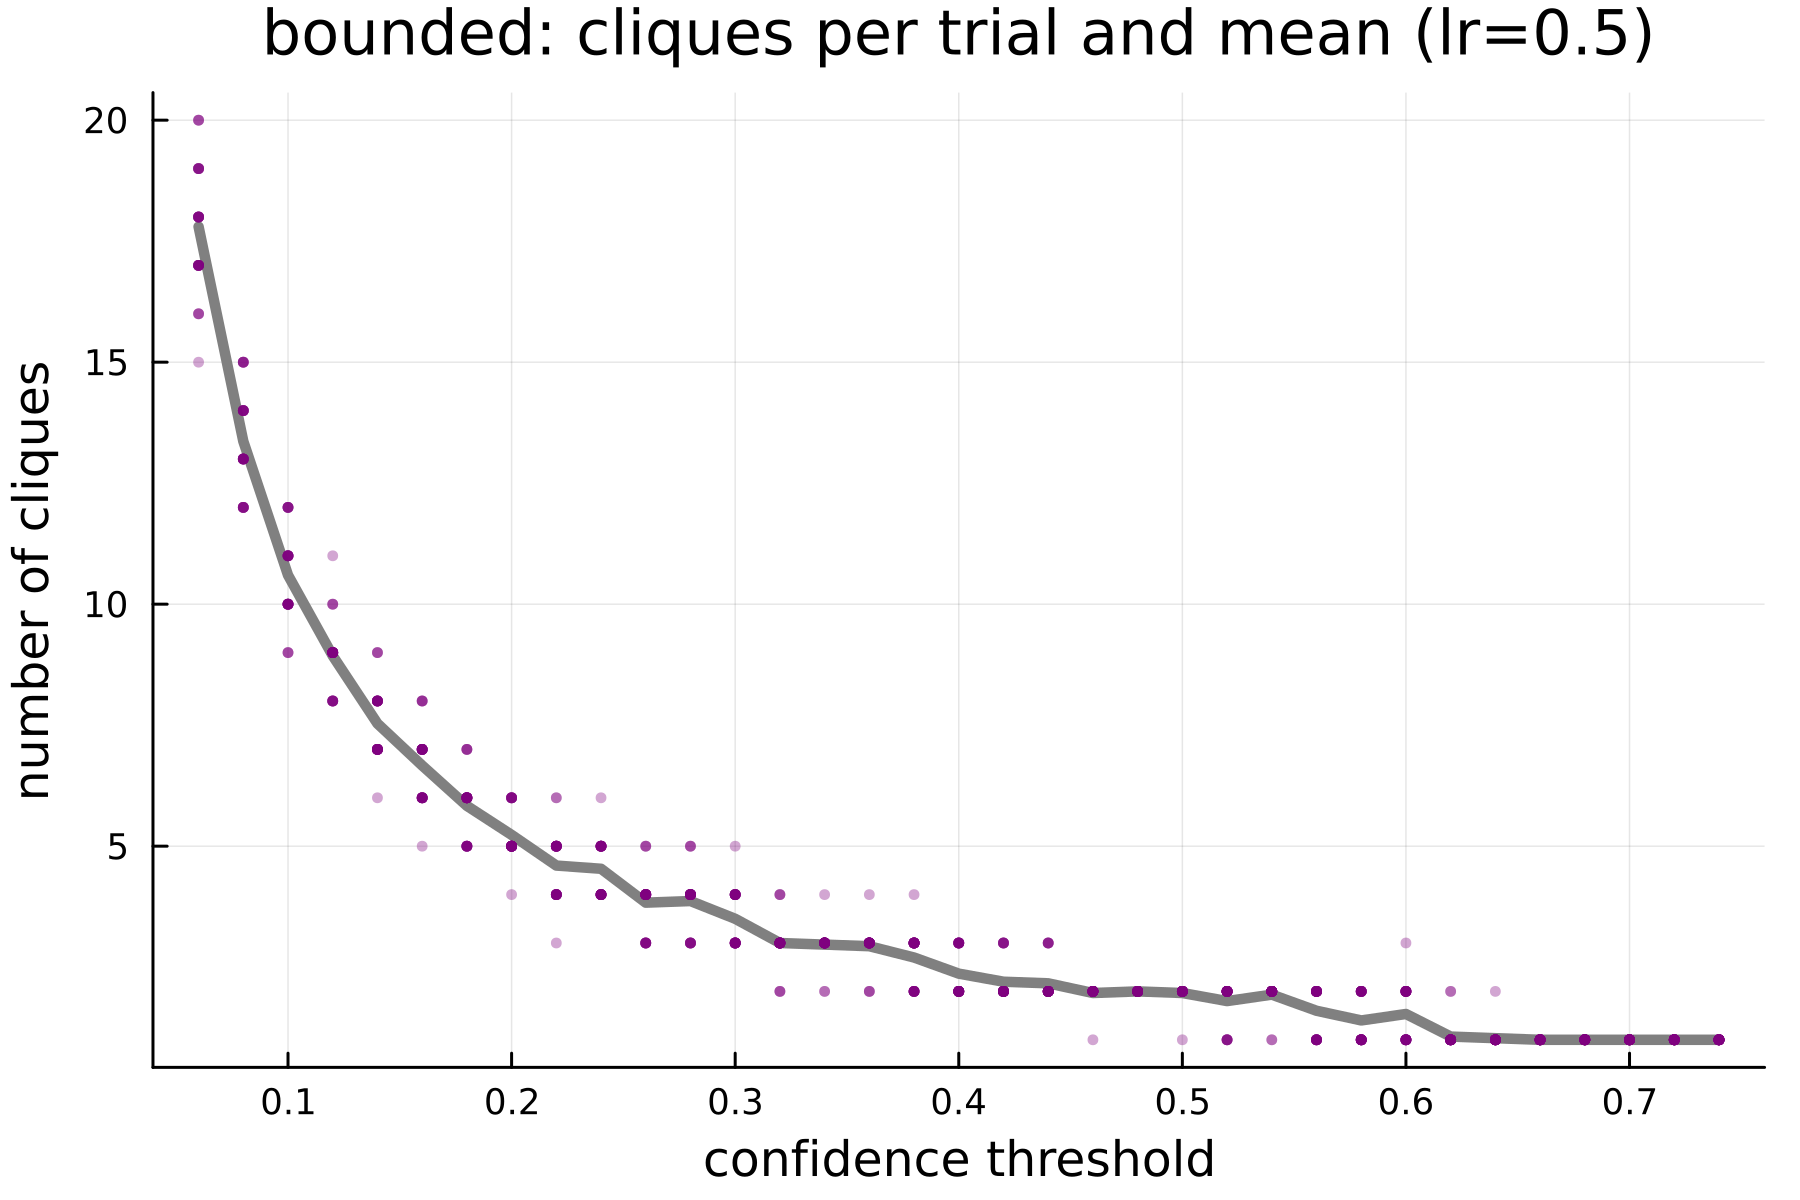

In [11]:
# Simulate and plot  
# Adjust parameters as needed for different scenarios
res = sweep_mechanism(; interaction_mode=:bounded,
    learning_rate_fixed=0.50,
    confidence_thresholds=collect(0.06:0.02:0.74),
    n_trials=30, M=21, local_int=false,
    max_steps=80000, batch_size=10 #adjust batch size based on number of workers and run time of trials
)


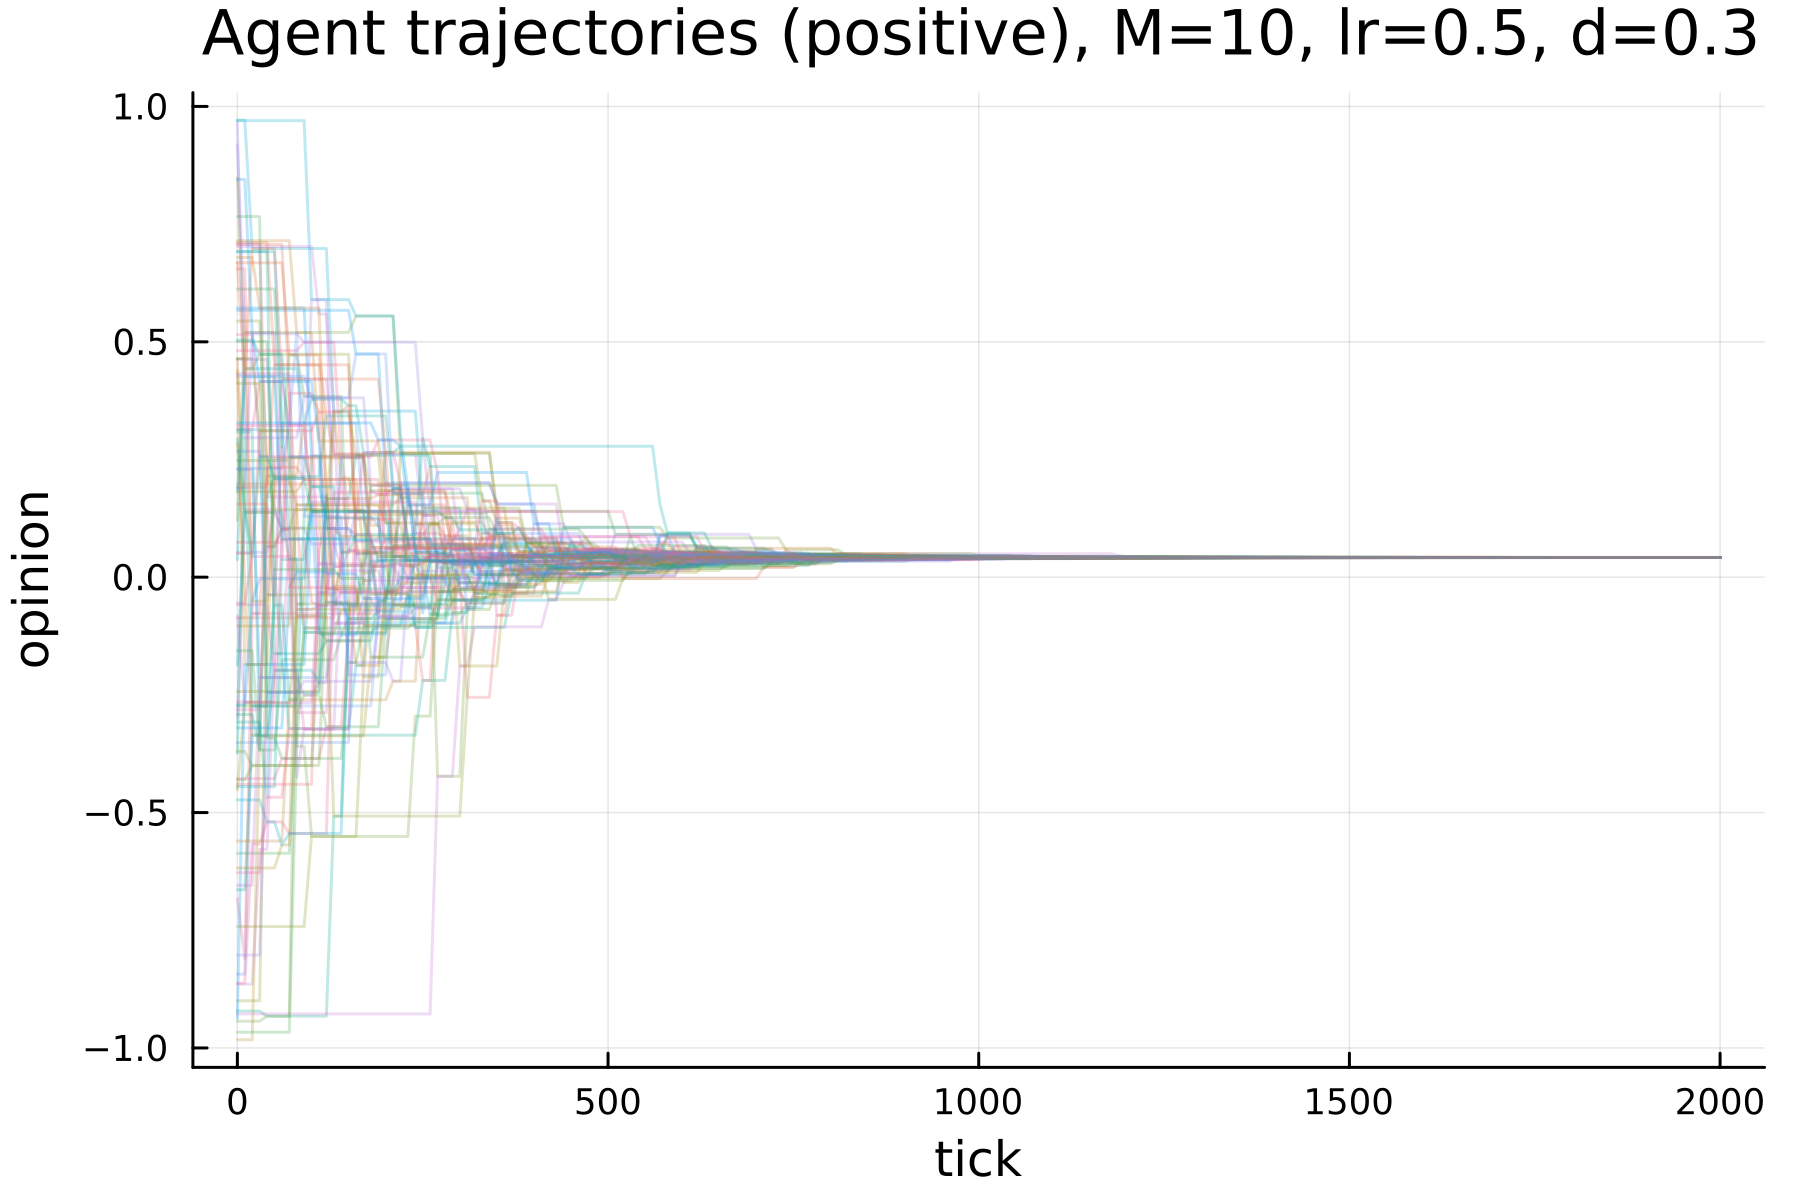

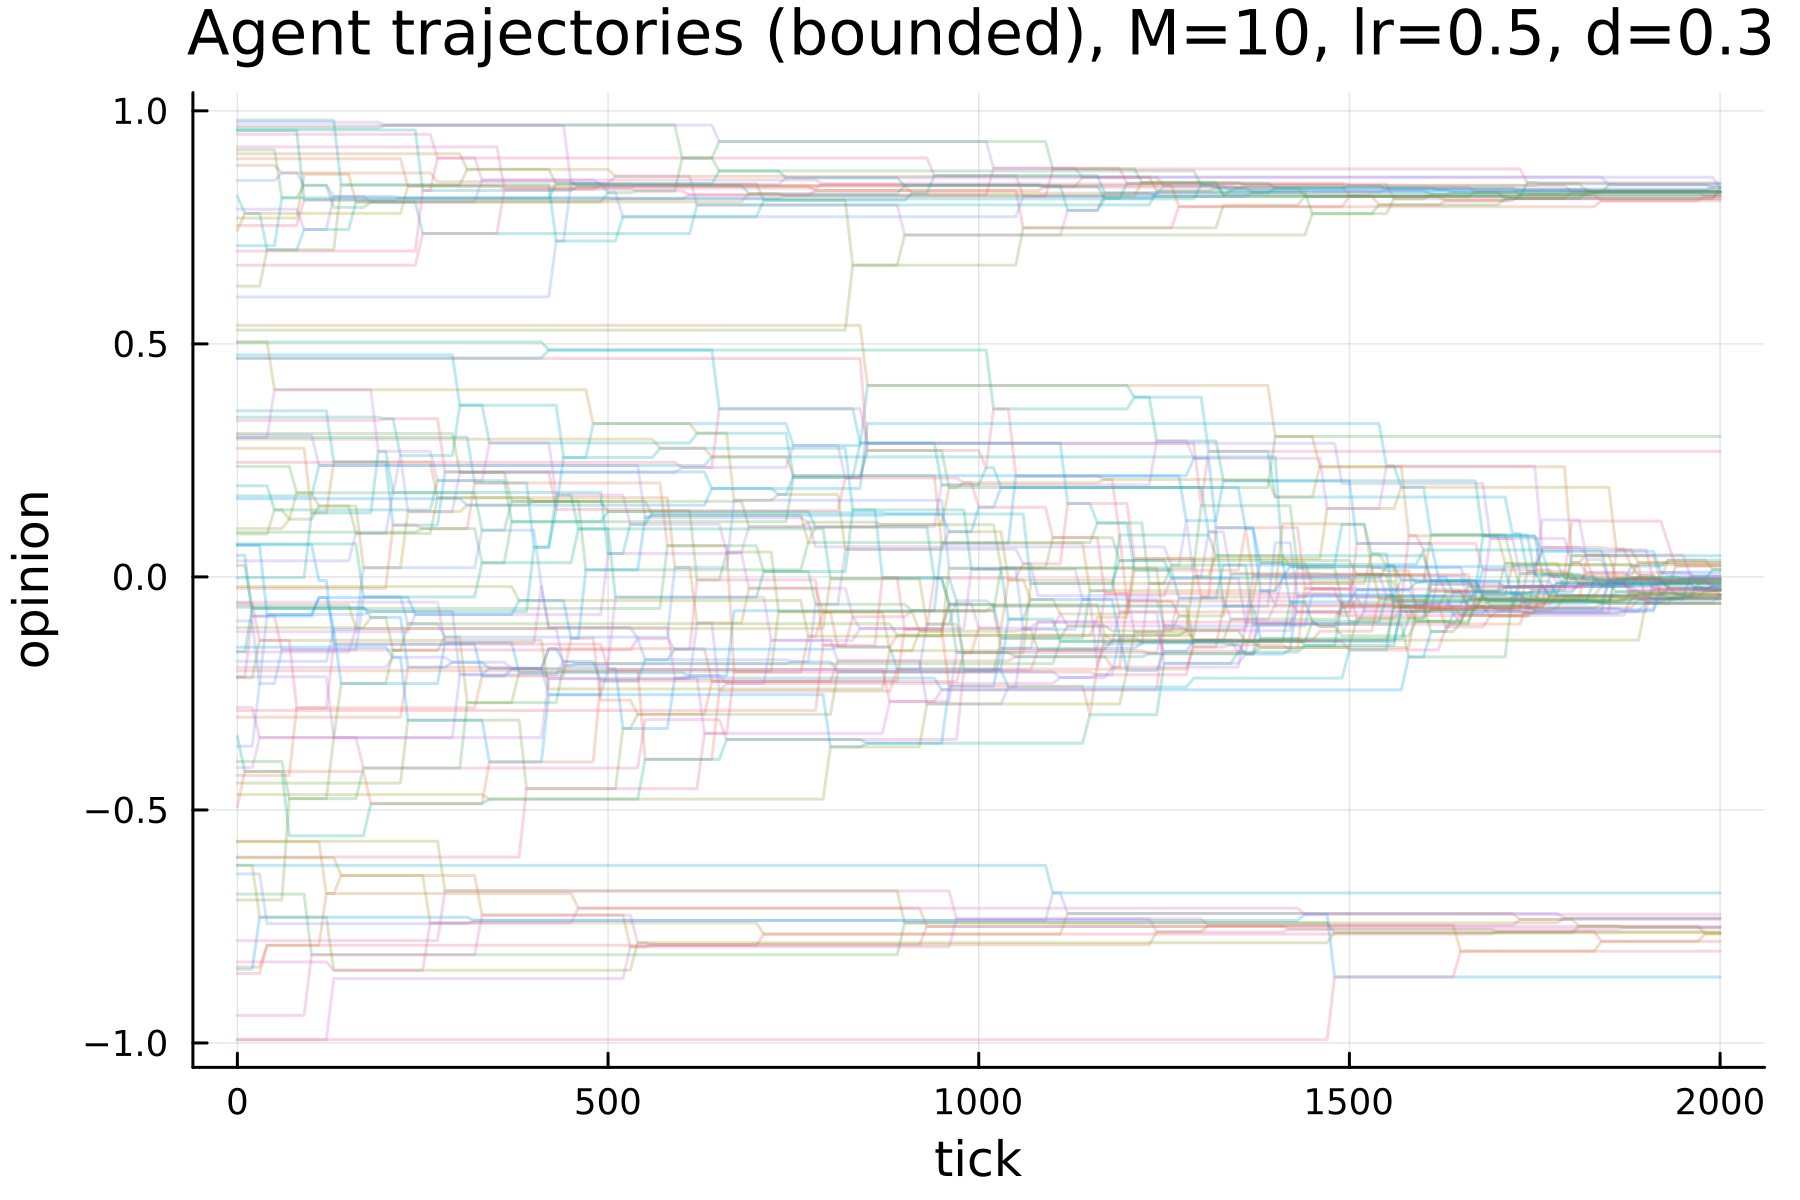

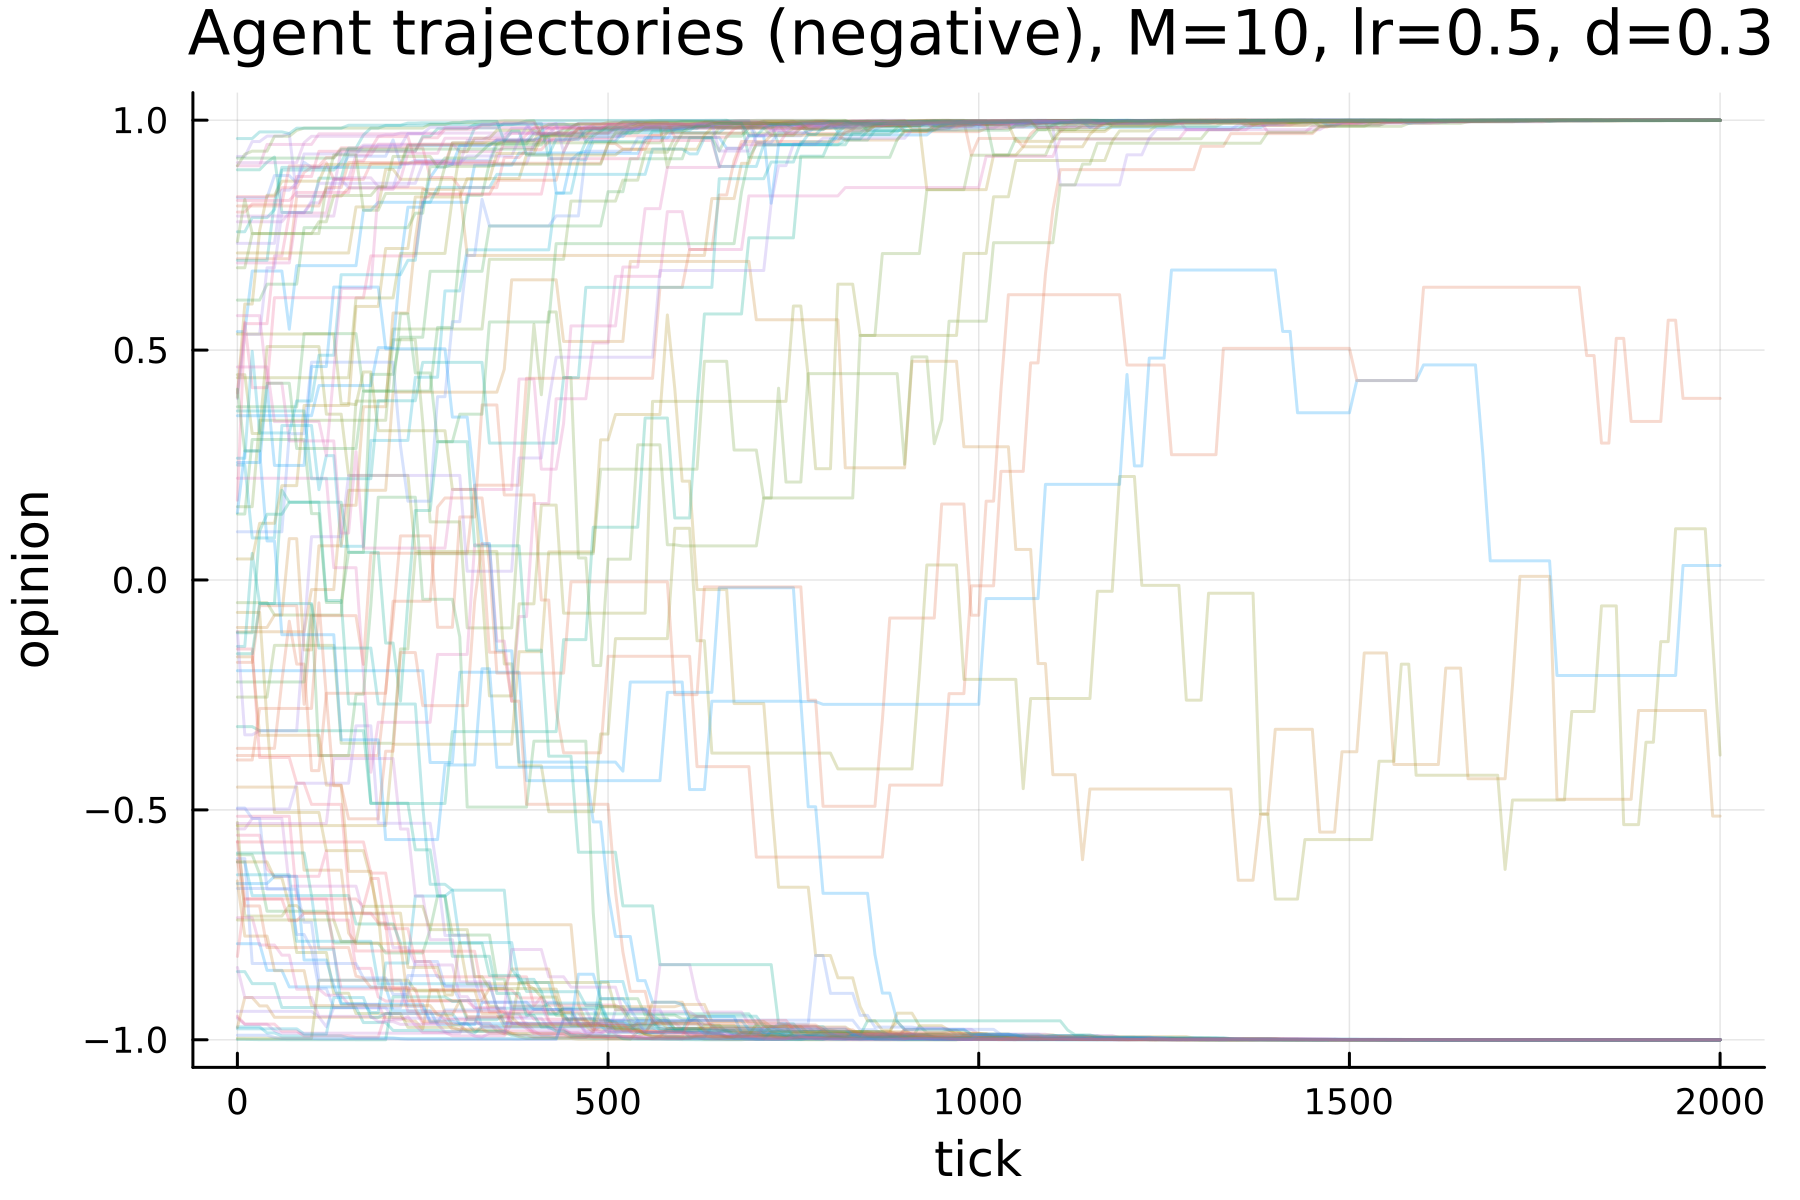

In [12]:
# Simulate and plot fixed ticks for all modes, well-mixed interactions
out = run_fixed_ticks_all_modes(; lr=0.5, confidence_threshold=0.3, M=10, local_int=false, ticks=2000, record_every=10) # increasing record_every lowers time to plot

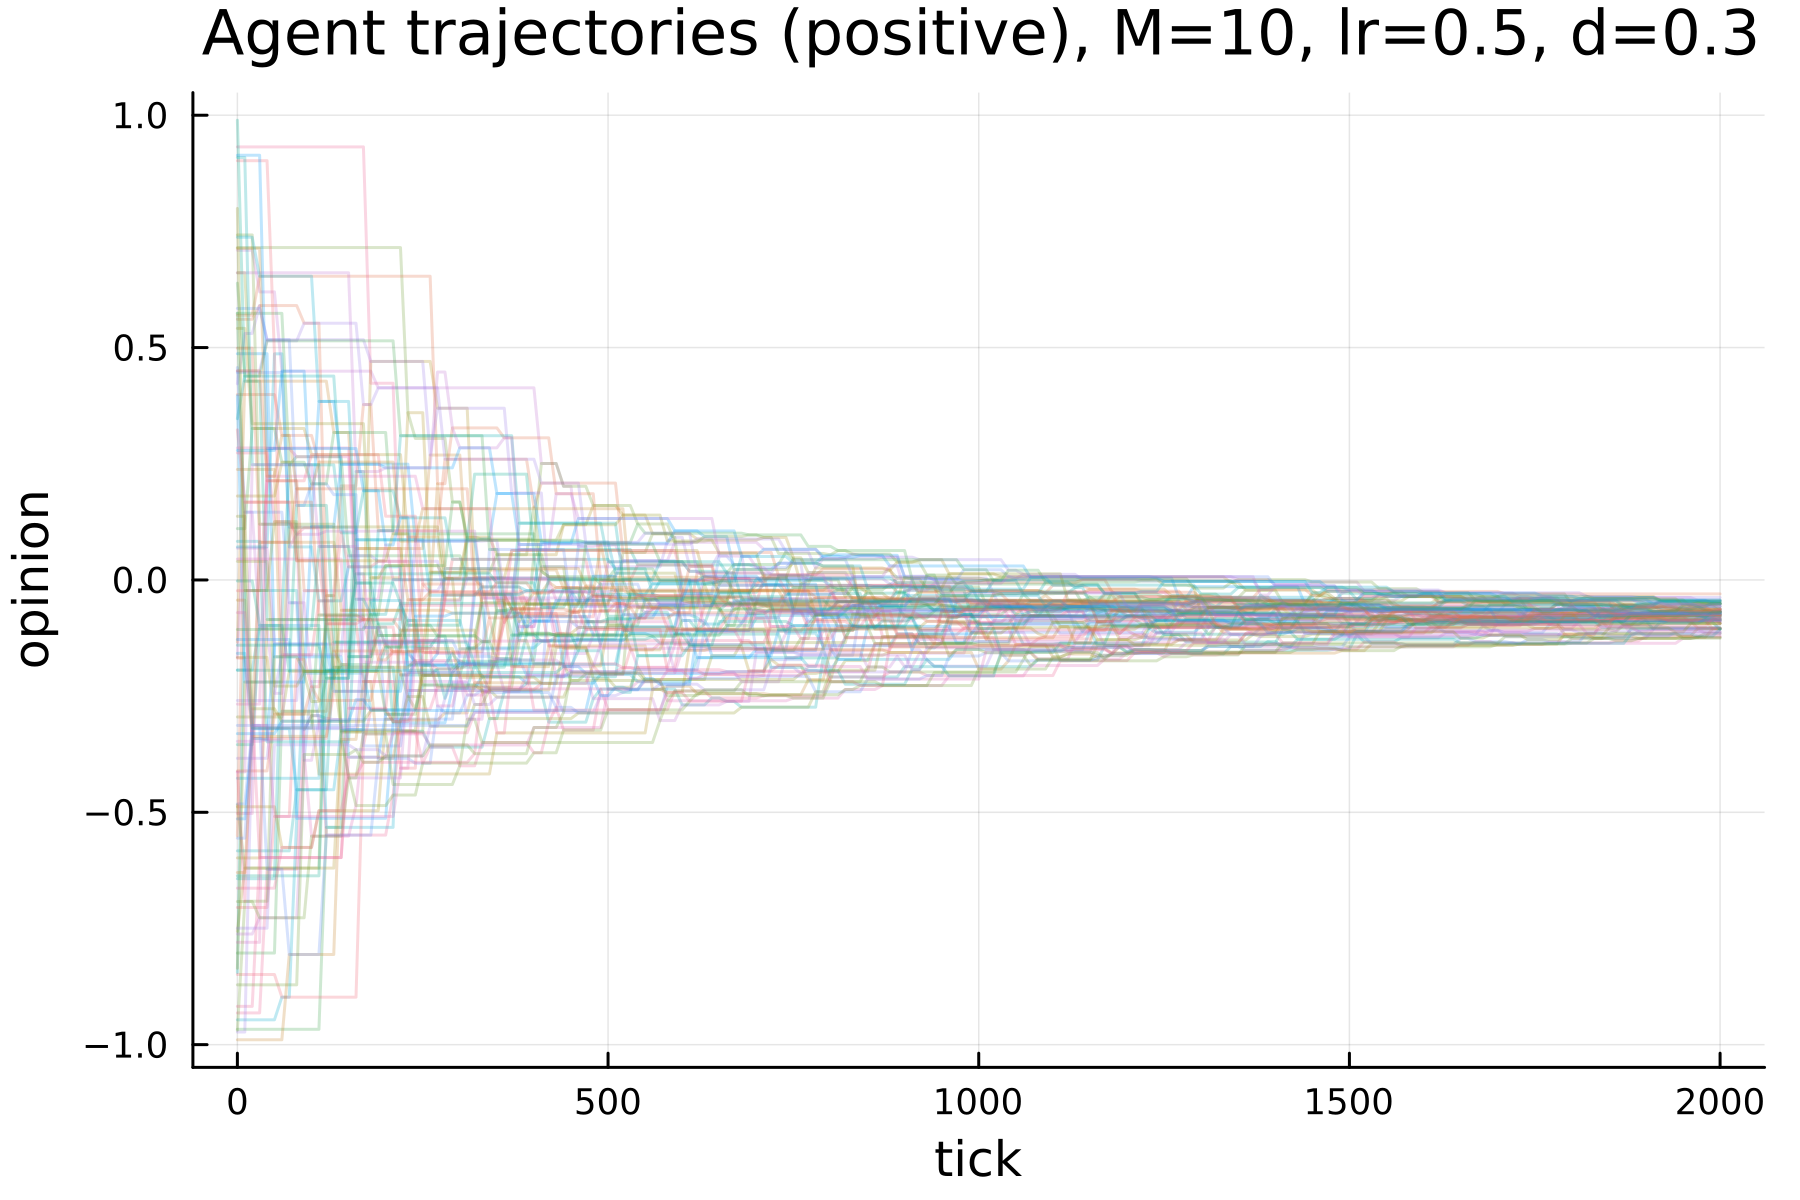

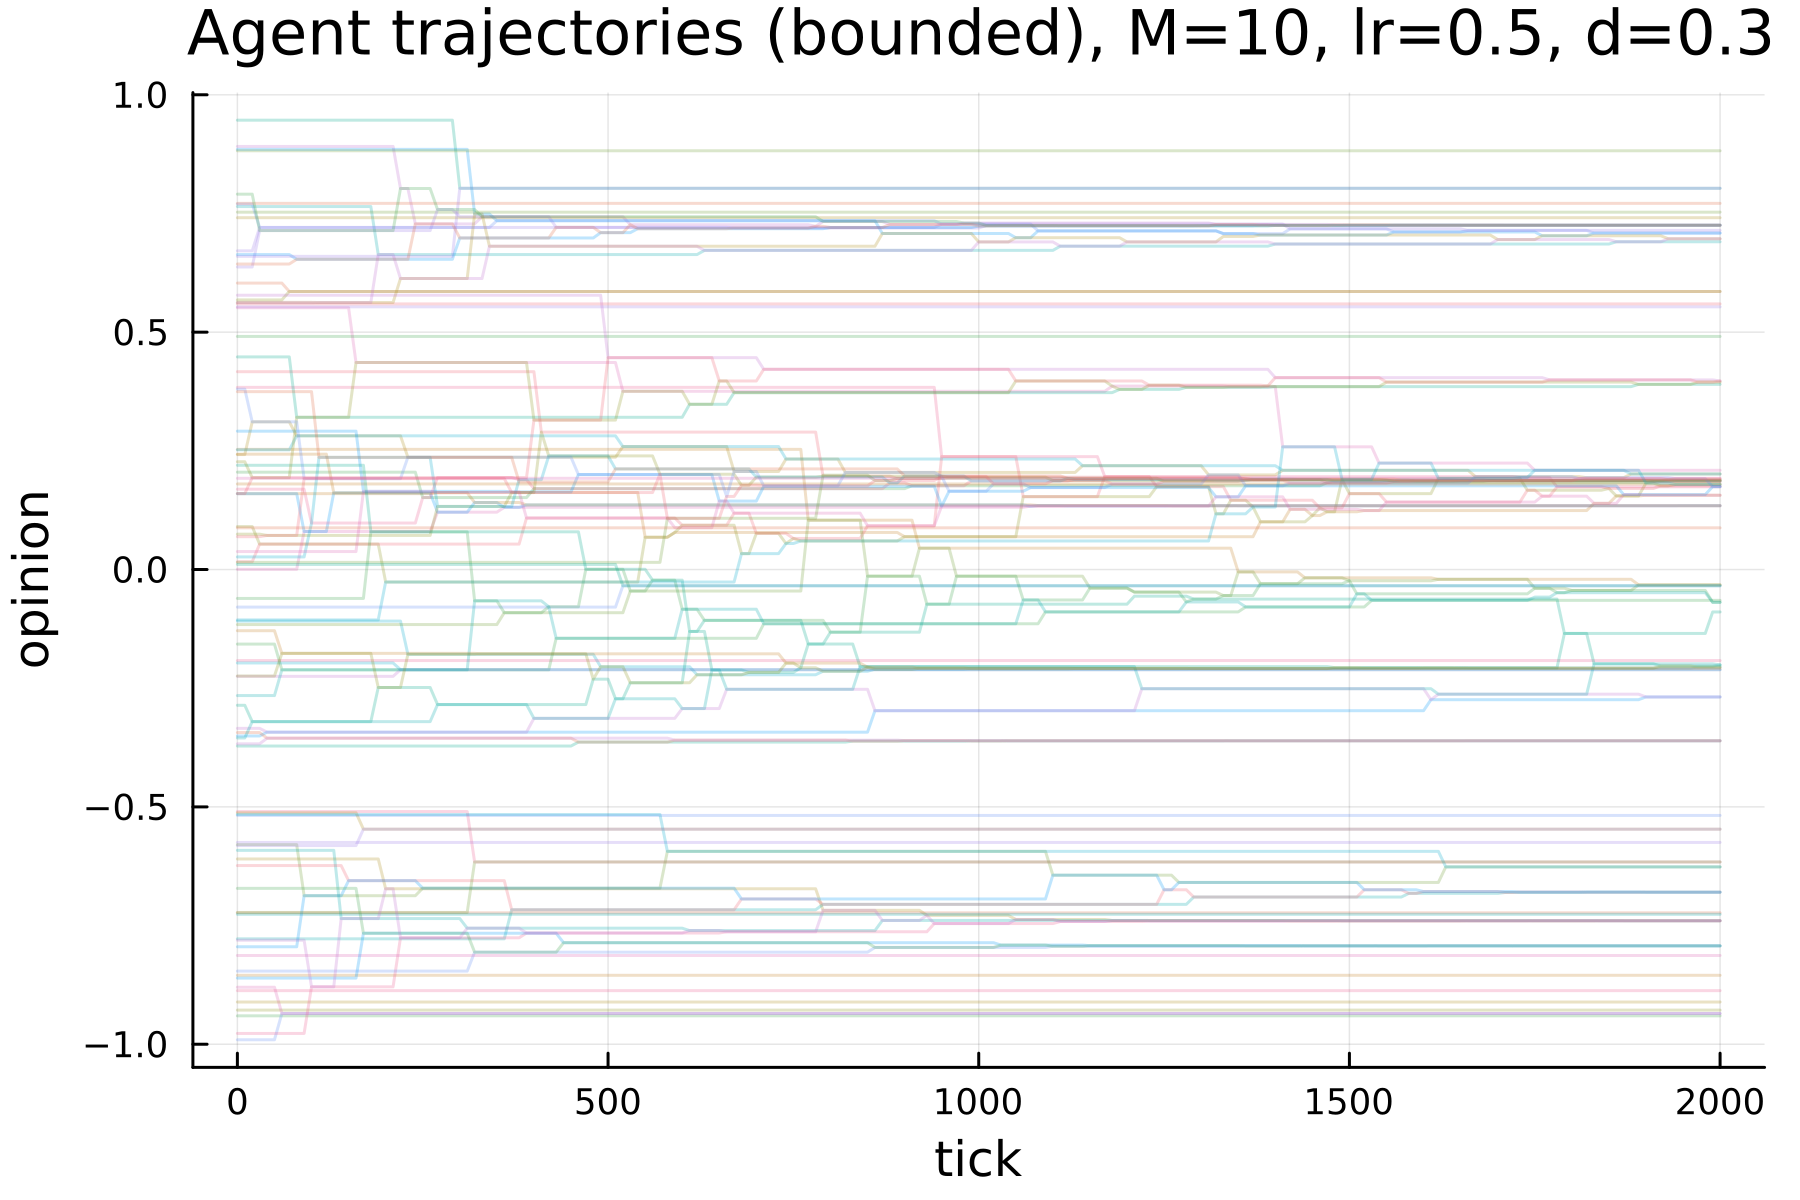

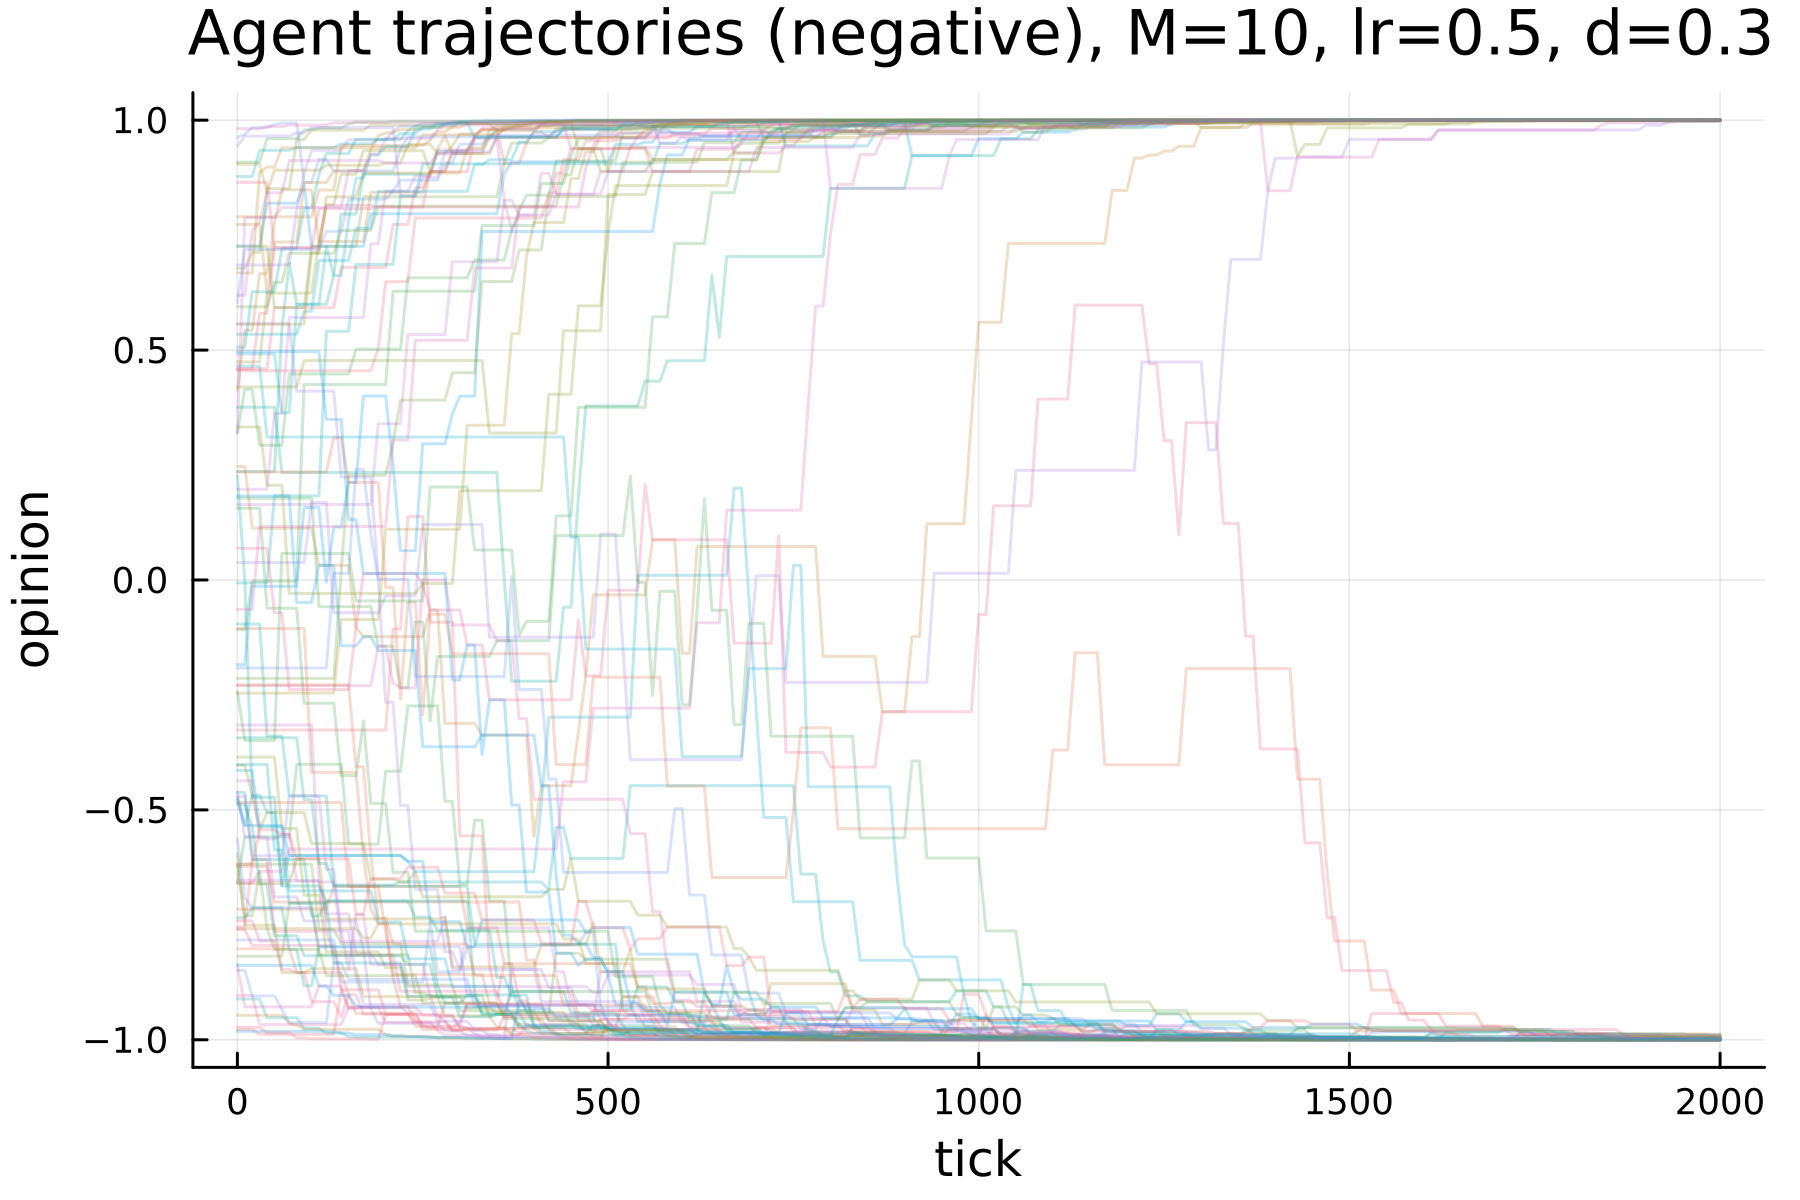

In [13]:
# Simulate and plot fixed ticks for all modes, local interactions
out = run_fixed_ticks_all_modes(; lr=0.5, confidence_threshold=0.3, M=10, local_int=true, ticks=2000, record_every=10)
